<a href="https://colab.research.google.com/github/Ys-Prakash/transcv/blob/master/A%20tutorial%20for%20SimCLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#hide
#skip
! [ -e /content ] && pip install -Uqq self-supervised
! pip install transcv nbdev fastai -q --upgrade

     |████████████████████████████████| 41 kB 480 kB/s 
     |████████████████████████████████| 336 kB 21.1 MB/s 
     |████████████████████████████████| 186 kB 47.7 MB/s 
     |████████████████████████████████| 376 kB 41.6 MB/s 
     |████████████████████████████████| 56 kB 4.2 MB/s 
     |████████████████████████████████| 46 kB 3.9 MB/s 
     |████████████████████████████████| 2.9 MB 18.8 MB/s 
     |████████████████████████████████| 51 kB 240 kB/s 
     |████████████████████████████████| 3.3 MB 37.7 MB/s 
     |████████████████████████████████| 895 kB 32.2 MB/s 
     |████████████████████████████████| 56 kB 5.0 MB/s 
     |████████████████████████████████| 636 kB 41.2 MB/s 
     |████████████████████████████████| 1.2 MB 24.6 MB/s 


In [ ]:
# hide
# all_slow

# A tutorial for SimCLR 
> In this tutorial, we will pre-train a ViT model, using SimCLR, and then, we shall fine-tune the model for a downstream visual recognition task. For a detailed and thorough explanation, it is recommended to first go through the tutorial notebooks of [this library](https://keremturgutlu.github.io/self_supervised/), and then this notebook.

## **Imports** 

In [ ]:
from fastai.vision.all import *
from transcv.visrectrans import *
torch.backends.cudnn.benchmark = True

In [ ]:
from self_supervised.augmentations import *
from self_supervised.layers import *
from self_supervised.vision.simclr import *

# **Datasets & Dataloaders for self-supervised pre-training** 

In [ ]:
def get_dls(size, bs, workers=None):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    
    files = get_image_files(source)
    tfms = [[PILImage.create, ToTensor, RandomResizedCrop(size, min_scale=1.)], 
            [parent_label, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=RandomSplitter(valid_pct=0.1)(files))
    
    batch_tfms = [IntToFloatTensor]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    return dls

In [ ]:
bs, resize, size = 8, 256, 224

In [ ]:
dls = get_dls(resize, bs)

# **ViT model**

Getting the ViT model, using the `VisRecTrans` class :

In [ ]:
vis_rec_ob = VisRecTrans('vit_small_patch16_224', 0, False)
model = vis_rec_ob.create_model()
vis_rec_ob.initialize(model)

/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:426: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


We need a module for extracting the class token, from the feature representation computed by the ViT : 

In [ ]:
class Encoder_transcv (Module) :
  def __init__ (self) :
    pass 
  def forward (self, x) : 
    x = x[:, 0]
    return x

In [ ]:
encoder = nn.Sequential(model[0], model[1], model[2], Encoder_transcv())

In [ ]:
def create_simclr_model(encoder, hidden_size=256, projection_size=128, bn=False, nlayers=2):
    "Create SimCLR model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,224,224)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers)
    apply_init(projector)
    return nn.Sequential(encoder, projector)

In [ ]:
model = create_simclr_model(encoder)

In [ ]:
aug_pipelines = get_simclr_aug_pipelines(size, rotate=True, rotate_deg=10, jitter=True, bw=True, blur=False) 

In [ ]:
cbs=[SimCLR(aug_pipelines)]

In [ ]:
learn = Learner(dls, model, cbs=cbs)

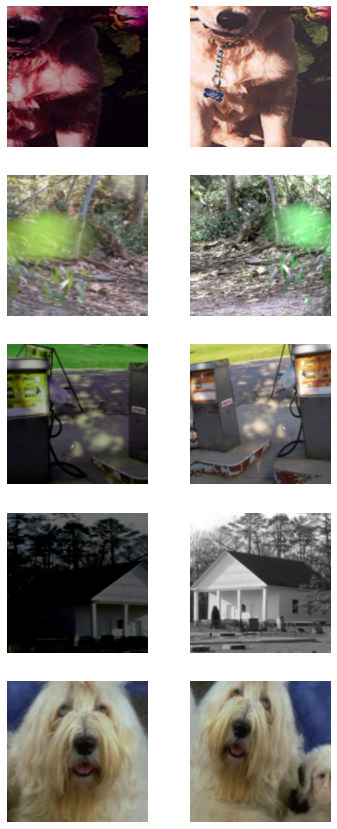

In [ ]:
b = dls.one_batch()
learn._split(b)
learn('before_batch')
learn.sim_clr.show(n=5);

In [ ]:
learn.to_fp16();

In [ ]:
lr,wd,epochs=1e-2,1e-2,100

SuggestedLRs(valley=0.0002290867705596611)

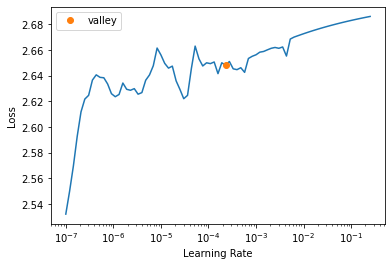

In [ ]:
learn.lr_find()

Since we have a different model for SimCLR, we need a custom `embed_callback` callback :

In [ ]:
class TrainEmbedCallback (Callback) :
  def before_train (self) :
    self.learn.model[0][1].training = True
    self.learn.model[0][1].requires_grad_(True)
  def before_validation (self) :
    self.learn.model[0][1].training = False
    self.learn.model[0][1].requires_grad_(False)

In [ ]:
learn.summary()

Sequential (Input shape: 8)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 384 x 14 x 14   
Conv2d                                    295296     True      
Identity                                                       
EmbedBlock                                                     
Dropout                                                        
LayerNorm                                 768        True      
____________________________________________________________________________
                     8 x 197 x 1152      
Linear                                    443520     True      
Dropout                                                        
Linear                                    147840     True      
Dropout                                                        
Identity                                                       
LayerNorm                                 768        True      
___________________________________________

## **Self-supervised pre-training**

In [ ]:
learn.unfreeze()
learn.fit_flat_cos(1, 1e-4, wd=wd, pct_start=0.5, cbs = [TrainEmbedCallback])

epoch,train_loss,valid_loss,time
0,1.516793,1.509312,46:02


Saving the parameters of the encoder :

In [ ]:
save_name = f'simclr_iwang_sz{size}_epc{epochs}'
learn.save(save_name)
encoder_path = learn.path/learn.model_dir/f'{save_name}_encoder.pth'
torch.save(learn.model[0].state_dict(), encoder_path)

In [ ]:
bs, size

(8, 224)

## **Datasets & Dataloaders for fine-tuning**

In [ ]:
def get_dls(size, bs, workers=None):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    files = get_image_files(source, folders=['train', 'val'])
    splits = GrandparentSplitter(valid_name='val')(files)
    
    item_aug = [RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
    tfms = [[PILImage.create, ToTensor, *item_aug], 
            [parent_label, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=splits)
    
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    return dls

## **Getting the learner for fine-tuning**

In [ ]:
def split_func(m): return L(m[0], m[1]).map(params)

def create_learner(size=size, encoder_path="models/swav_iwang_sz128_epc100_encoder.pth"):
    
    dls = get_dls(size, bs=bs)
    pretrained_encoder = torch.load(encoder_path)
    vis_rec_ob = VisRecTrans('vit_small_patch16_224', 0, False)
    model = vis_rec_ob.create_model()
    vis_rec_ob.initialize(model)
    encoder = nn.Sequential(model[0], model[1], model[2], Encoder_transcv())
    encoder.load_state_dict(pretrained_encoder)
    nf = encoder(torch.randn(2,3,224,224)).size(-1)
    classifier = create_cls_module(nf, dls.c)
    model = nn.Sequential(encoder, classifier)
    learn = Learner(dls, model, splitter=split_func,
                metrics=top_k_accuracy, loss_func=LabelSmoothingCrossEntropy())
    return learn

/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:426: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


SuggestedLRs(valley=0.0008317637839354575)

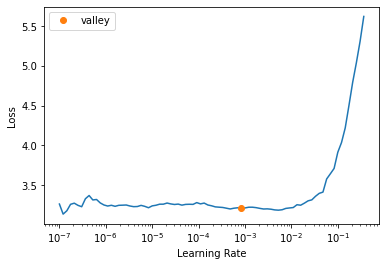

In [ ]:
learn = create_learner(size, encoder_path)
learn.unfreeze()
learn.lr_find()

## **Fine-tuning**

In [ ]:
learn.fit_one_cycle(5, 1e-4, cbs = TrainEmbedCallback)

epoch,train_loss,valid_loss,top_k_accuracy,time
0,2.593372,3.329553,0.185798,06:50
1,2.247928,3.347796,0.293713,06:49
2,1.952943,3.466967,0.238483,06:50
3,1.840052,3.220397,0.405447,06:49
4,1.861218,3.188895,0.435225,06:50
